In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import keras_tuner as kt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Dense, Dropout, BatchNormalization, Bidirectional
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

2024-12-06 17:43:03.702289: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-12-06 17:43:03.894546: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-12-06 17:43:04.076768: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1733481784.249242    5510 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1733481784.299360    5510 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-06 17:43:04.675415: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU ins

In [2]:
data = pd.read_csv('../Data/expenses_income_summary.csv')
data.head()

,Date,title,category,account,amount,currency,type,transfer-amount,transfer-currency,to-account,receive-amount,receive-currency,description,due-date,id
0,2024-08-11 13:56:59.652,Karthik,Bills & Fees,Savings Bank,45.00,INR,EXPENSE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,74e78631-db14-4495-bfb9-85546b0bd2fe
1,2024-08-10 16:09:55.986,Juice,Food & Drinks,Cash,40.00,INR,EXPENSE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,65e12e62-9f63-4c6c-b452-6c7b42fbfb7f
2,2024-08-09 10:25:21.618,Tire,Transport,Cash,10.00,INR,EXPENSE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9ecd93bd-a835-4263-86e2-99fea475fa37
3,2024-08-07 03:57:24.944,Baba,Bills & Fees,Savings Bank,200.00,INR,EXPENSE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,00d39b2c-e722-485a-85ca-28f6506dc674
4,2024-08-04 13:09:08.452,Reward,Bills & Fees,Salary Bank,4.00,INR,INCOME,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3861d205-3245-4926-ad69-4491b0bff547


In [3]:
data['amount'].describe()

count      1155
unique      185
top       20.00
freq        162
Name: amount, dtype: object

# Data Cleaning

In [4]:
data['Date'] = pd.to_datetime(data['Date'], errors='coerce')

data = data.dropna(subset=['Date', 'amount']) 

data['amount'] = data['amount'].replace({',': ''}, regex=True).astype(float)

# data['amount'] = data['amount'] * 187.88

data = data[data['type'] == 'EXPENSE']

In [5]:
data.head()

,Date,title,category,account,amount,currency,type,transfer-amount,transfer-currency,to-account,receive-amount,receive-currency,description,due-date,id
0,2024-08-11 13:56:59.652,Karthik,Bills & Fees,Savings Bank,45.0,INR,EXPENSE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,74e78631-db14-4495-bfb9-85546b0bd2fe
1,2024-08-10 16:09:55.986,Juice,Food & Drinks,Cash,40.0,INR,EXPENSE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,65e12e62-9f63-4c6c-b452-6c7b42fbfb7f
2,2024-08-09 10:25:21.618,Tire,Transport,Cash,10.0,INR,EXPENSE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9ecd93bd-a835-4263-86e2-99fea475fa37
3,2024-08-07 03:57:24.944,Baba,Bills & Fees,Savings Bank,200.0,INR,EXPENSE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,00d39b2c-e722-485a-85ca-28f6506dc674
5,2024-08-04 13:07:41.831,Baba,Bills & Fees,Savings Bank,500.0,INR,EXPENSE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,d56409a4-8deb-4a73-84e7-dfcc630b90dd


In [6]:
columns_to_drop = data.loc[:, 'transfer-amount':'id'].columns

# Menghapus kolom-kolom tersebut
data = data.drop(columns=columns_to_drop)

In [7]:
data['category'] = data['category'].fillna('Other')

In [8]:
data.head()

,Date,title,category,account,amount,currency,type
0,2024-08-11 13:56:59.652,Karthik,Bills & Fees,Savings Bank,45.0,INR,EXPENSE
1,2024-08-10 16:09:55.986,Juice,Food & Drinks,Cash,40.0,INR,EXPENSE
2,2024-08-09 10:25:21.618,Tire,Transport,Cash,10.0,INR,EXPENSE
3,2024-08-07 03:57:24.944,Baba,Bills & Fees,Savings Bank,200.0,INR,EXPENSE
5,2024-08-04 13:07:41.831,Baba,Bills & Fees,Savings Bank,500.0,INR,EXPENSE


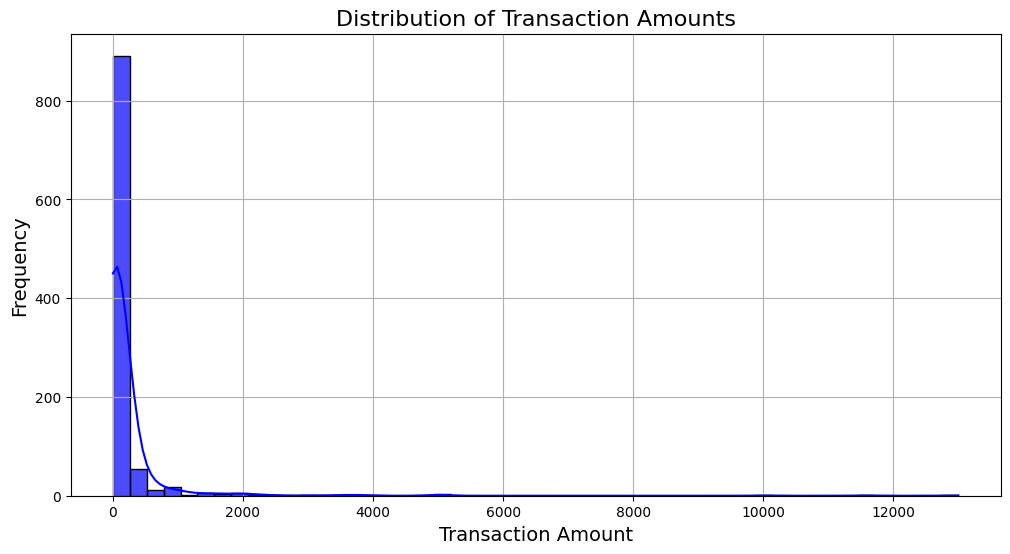

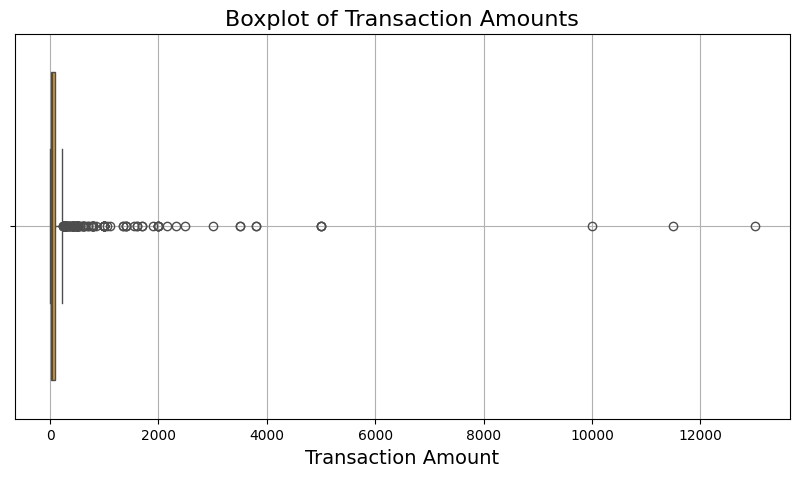

In [9]:
# Visualisasi distribusi data (histogram)
plt.figure(figsize=(12, 6))
sns.histplot(data['amount'], bins=50, kde=True, color='blue', alpha=0.7)
plt.title('Distribution of Transaction Amounts', fontsize=16)
plt.xlabel('Transaction Amount', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.grid(True)
plt.show()

# Visualisasi outliers dengan boxplot
plt.figure(figsize=(10, 5))
sns.boxplot(x=data['amount'], color='orange')
plt.title('Boxplot of Transaction Amounts', fontsize=16)
plt.xlabel('Transaction Amount', fontsize=14)
plt.grid(True)
plt.show()


In [10]:
# Mengecek nilai maksimum dalam kolom 'amount'
min_value = data['amount'].min()
print(f"Nilai minimum dalam data: {min_value}")
max_value = data['amount'].max()
print(f"Nilai maksimum dalam data: {max_value}")


Nilai minimum dalam data: 0.9
Nilai maksimum dalam data: 13000.0


## ***IQR Methode cleaning outlier***

In [11]:
Q1 = data['amount'].quantile(0.25)
Q3 = data['amount'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
print(f"Lower Bound: {lower_bound}")
print(f"Upper Bound: {upper_bound}")

data = data[(data['amount'] >= lower_bound) & (data['amount'] <= upper_bound)]

Lower Bound: -100.0
Upper Bound: 220.0


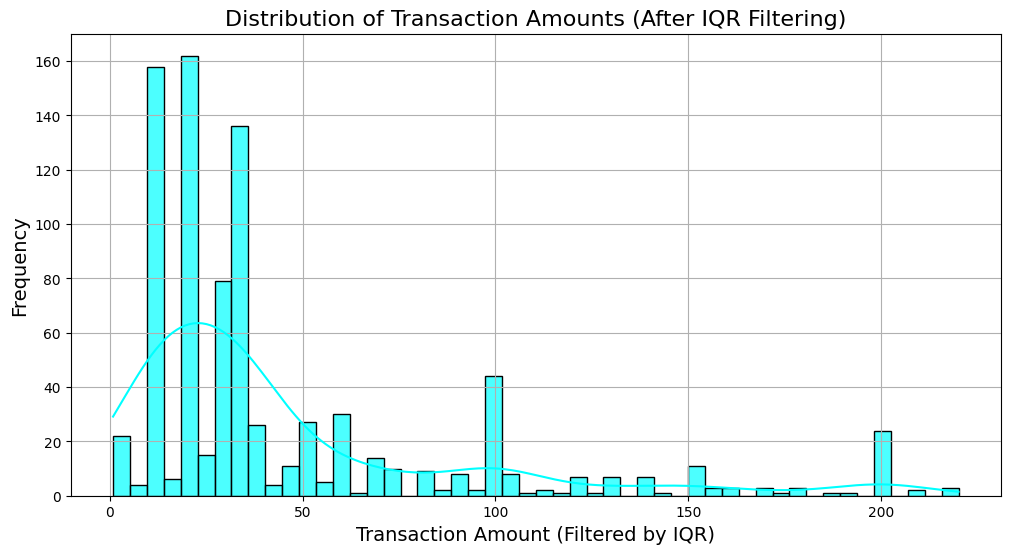

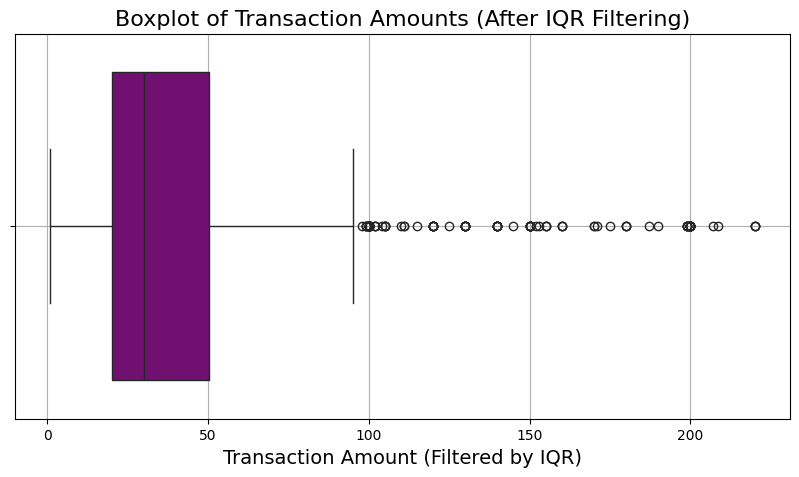

In [12]:
# Visualisasi hasil IQR filtering
plt.figure(figsize=(12, 6))
sns.histplot(data['amount'], bins=50, kde=True, color='cyan', alpha=0.7)
plt.title('Distribution of Transaction Amounts (After IQR Filtering)', fontsize=16)
plt.xlabel('Transaction Amount (Filtered by IQR)', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.grid(True)
plt.show()

# Boxplot setelah IQR filtering
plt.figure(figsize=(10, 5))
sns.boxplot(x=data['amount'], color='purple')
plt.title('Boxplot of Transaction Amounts (After IQR Filtering)', fontsize=16)
plt.xlabel('Transaction Amount (Filtered by IQR)', fontsize=14)
plt.grid(True)
plt.show()


/tmp/ipykernel_5510/471868810.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y=large_expenses['category'], order=large_expenses['category'].value_counts().index, palette="viridis")


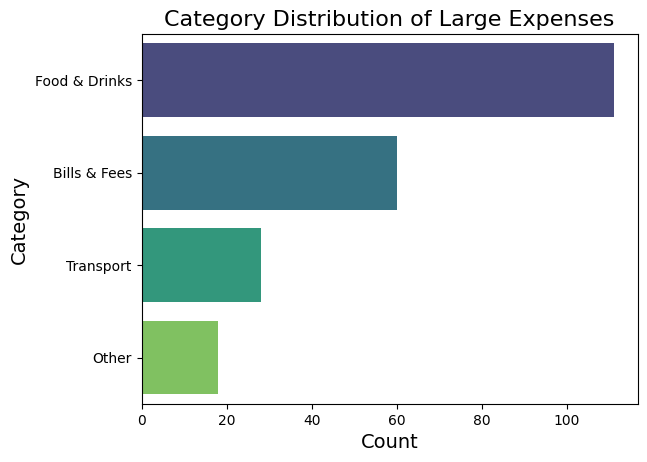

In [13]:
large_expenses = data[data['amount'] > 50]
sns.countplot(y=large_expenses['category'], order=large_expenses['category'].value_counts().index, palette="viridis")
plt.title('Category Distribution of Large Expenses', fontsize=16)
plt.xlabel('Count', fontsize=14)
plt.ylabel('Category', fontsize=14)
plt.show()


In [14]:
# data

## Preprocessing 

In [15]:
# Normalisasi log Feature
data['amount'] = np.log1p(data['amount'])

# Feature days of weeks or weekend
data['day_of_week'] = pd.to_datetime(data['Date']).dt.dayofweek
data['is_weekend'] = (data['day_of_week'] >= 5).astype(int)

# Smoothing menggunakan rata-rata bergerak
data['smoothed_expenses'] = data['amount'].rolling(window=3, min_periods=1).mean()

# Encoding cyclic untuk hari dalam minggu
data['day_of_week_sin'] = np.sin(2 * np.pi * data['day_of_week'] / 7)
data['day_of_week_cos'] = np.cos(2 * np.pi * data['day_of_week'] / 7)

# Rolling averages (trend jangka panjang)
data['rolling_avg_7'] = data['amount'].rolling(window=7, min_periods=1).mean()
data['rolling_avg_30'] = data['amount'].rolling(window=30, min_periods=1).mean()

# Lag Features
data['Lag_1_Expenses'] = data['amount'].shift(1)
data['Lag_2_Expenses'] = data['amount'].shift(2)

# Hapus baris dengan nilai NaN akibat shift
data.dropna(subset=['Lag_1_Expenses', 'Lag_2_Expenses'], inplace=True)

# Encoding kategori
data['category_encoded'] = data['category'].astype('category').cat.codes

# Add New Feature in Dataset
features = data[['Lag_1_Expenses', 'Lag_2_Expenses', 'category_encoded',
                         'day_of_week_sin', 'day_of_week_cos', 'is_weekend',
                         'smoothed_expenses', 'rolling_avg_7', 'rolling_avg_30']].values
target = data['amount'].values

# Normalisasi Feature
# scaler = MinMaxScaler()
# features_scaled = scaler.fit_transform(features)

# Split data ke dalam train/test set
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

# Build up data for CNN + LSTM (dimensi 3D)
X_train_reshaped = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test_reshaped = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")
# print(f"Nilai Scaler = {scaler}, Nilai Feature_Scale = {features_scaled}")


X_train shape: (690, 9), y_train shape: (690,)
X_test shape: (173, 9), y_test shape: (173,)


In [16]:
# import joblib
# joblib.dump(scaler, 'scaler.pkl')

In [17]:
data.isnull().sum()

Date                  0
title                10
category              0
account               0
amount                0
currency              0
type                  0
day_of_week           0
is_weekend            0
smoothed_expenses     0
day_of_week_sin       0
day_of_week_cos       0
rolling_avg_7         0
rolling_avg_30        0
Lag_1_Expenses        0
Lag_2_Expenses        0
category_encoded      0
dtype: int64

In [18]:
data.loc[data['category_encoded'] == 4, ['category', 'category_encoded']]

,category,category_encoded


0 = Bills & Fees
1 = Food & Drinks	
2 = Other
3 = Transport

## HyperTuning

In [19]:
import keras_tuner as kt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, LSTM, Dense, Dropout, BatchNormalization, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.initializers import GlorotUniform

def build_model(hp):
    model = Sequential([
        Input(batch_shape=(None, 10, 1)),
        Conv1D(
            filters=hp.Int('filters', min_value=32, max_value=128, step=16),
            kernel_size=hp.Choice('kernel_size', values=[3, 5, 7, 9]),
            activation='relu',
            # input_shape=(10, 1)
        ),
        MaxPooling1D(pool_size=2),
        BatchNormalization(),
        Bidirectional(LSTM(
            units=hp.Int('lstm_units', min_value=32, max_value=128, step=16),
            return_sequences=True,
            kernel_initializer=GlorotUniform(),
            recurrent_initializer=GlorotUniform(),  # Pastikan ini diubah
            dropout=hp.Float('dropout', min_value=0.2, max_value=0.5, step=0.1)
        )),
        LSTM(
            units=hp.Int('lstm_units_2', min_value=16, max_value=64, step=16),
            kernel_initializer=GlorotUniform(),
            recurrent_initializer=GlorotUniform(),  # Pastikan ini diubah
            dropout=hp.Float('dropout_2', min_value=0.1, max_value=0.5, step=0.1)
        ),
        Dense(units=hp.Int('dense_units', min_value=16, max_value=128, step=16), activation='relu'),
        Dense(1)
    ])
    model.compile(
        optimizer=hp.Choice('optimizer', values=['adam', 'rmsprop']),
        loss='mse',
        metrics=['mae']
    )
    return model

# Inisialisasi tuner
tuner = kt.BayesianOptimization(
    build_model,
    objective='val_mae',
    max_trials=20,
    executions_per_trial=2,
    directory='bayesian_tuning',
    project_name='expense_prediction'
)

# Callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Search hyperparameters
tuner.search(
    X_train_reshaped, y_train,
    validation_data=(X_test_reshaped, y_test),
    epochs=50,
    batch_size=32,
    callbacks=[early_stopping]
)

# Print best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"Best Hyperparameters:\n{best_hps.values}")

# Simpan model terbaik
best_model = tuner.hypermodel.build(best_hps)
best_model.fit(
    X_train_reshaped, y_train,
    validation_data=(X_test_reshaped, y_test),
    epochs=50,
    batch_size=32,
    callbacks=[early_stopping]
)
test_loss, test_mae = best_model.evaluate(X_test_reshaped, y_test)
print(f"Test Loss: {test_loss}, Test MAE: {test_mae}")
best_model.summary()


Reloading Tuner from bayesian_tuning/expense_prediction/tuner0.json


2024-12-06 17:43:12.341055: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Best Hyperparameters:
{'filters': 112, 'kernel_size': 3, 'lstm_units': 128, 'dropout': 0.30000000000000004, 'lstm_units_2': 64, 'dropout_2': 0.4, 'dense_units': 128, 'optimizer': 'adam'}
Epoch 1/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 12s 71ms/step - loss: 8.3717 - mae: 2.6144 - val_loss: 6.2815 - val_mae: 2.3578
Epoch 2/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.6739 - mae: 0.6496 - val_loss: 4.8825 - val_mae: 2.0552
Epoch 3/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.6018 - mae: 0.5955 - val_loss: 3.9917 - val_mae: 1.8441
Epoch 4/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.5491 - mae: 0.5730 - val_loss: 3.4084 - val_mae: 1.6925
Epoch 5/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.4412 - mae: 0.5196 - val_loss: 2.6501 - val_mae: 1.4777
Epoch 6/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.4026 - mae: 0.4835 - val_loss: 2.0878 - val_mae: 1.3000
Epoch 7/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.3364 - mae: 0.4499 - val_loss: 1.5588 - val_mae: 

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 8, 112)         │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 4, 112)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 4, 112)         │           448 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 4, 256)         │       246,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │        82,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,014,469 (3.87 MB)

 Trainable params: 338,081 (1.29 MB)

 Non-trainable params: 224 (896.00 B)

 Optimizer params: 676,164 (2.58 MB)

## Train And Evaluate Model

In [20]:
# Build Model
model = tuner.hypermodel.build(best_hps)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(
    X_train_reshaped, y_train,
    validation_data=(X_test_reshaped, y_test),
    epochs=50,
    batch_size=32,
    verbose=2,
    callbacks=[reduce_lr, early_stopping]
)

Epoch 1/50
22/22 - 13s - 583ms/step - loss: 5.5339 - mae: 1.9792 - val_loss: 5.9038 - val_mae: 2.2862 - learning_rate: 1.0000e-03
Epoch 2/50
22/22 - 0s - 17ms/step - loss: 0.7129 - mae: 0.6650 - val_loss: 4.8619 - val_mae: 2.0590 - learning_rate: 1.0000e-03
Epoch 3/50
22/22 - 0s - 20ms/step - loss: 0.5399 - mae: 0.5767 - val_loss: 4.0657 - val_mae: 1.8693 - learning_rate: 1.0000e-03
Epoch 4/50
22/22 - 1s - 23ms/step - loss: 0.5022 - mae: 0.5519 - val_loss: 3.8179 - val_mae: 1.8127 - learning_rate: 1.0000e-03
Epoch 5/50
22/22 - 0s - 19ms/step - loss: 0.4188 - mae: 0.5036 - val_loss: 3.0928 - val_mae: 1.6174 - learning_rate: 1.0000e-03
Epoch 6/50
22/22 - 0s - 17ms/step - loss: 0.3761 - mae: 0.4691 - val_loss: 2.3065 - val_mae: 1.3810 - learning_rate: 1.0000e-03
Epoch 7/50
22/22 - 0s - 17ms/step - loss: 0.3105 - mae: 0.4448 - val_loss: 1.8147 - val_mae: 1.2155 - learning_rate: 1.0000e-03
Epoch 8/50
22/22 - 0s - 22ms/step - loss: 0.2505 - mae: 0.3910 - val_loss: 1.3053 - val_mae: 1.0244 - 

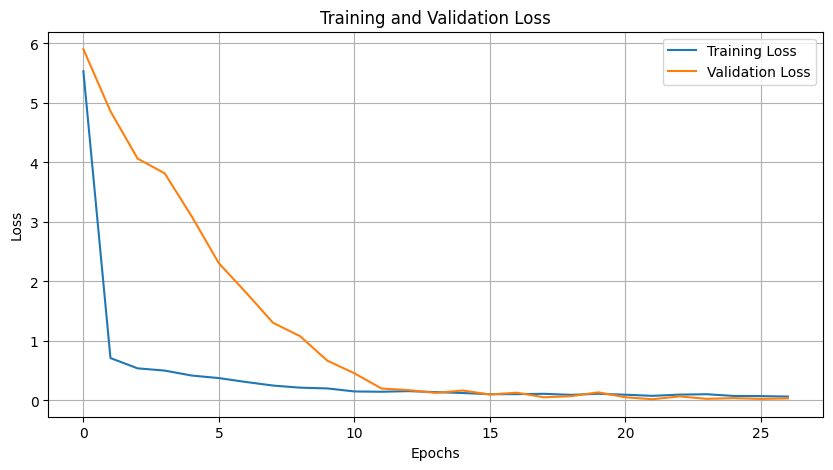

In [21]:
history_data = history.history

plt.figure(figsize=(10, 5))
plt.plot(history_data['loss'], label='Training Loss')
plt.plot(history_data['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid()
plt.show()

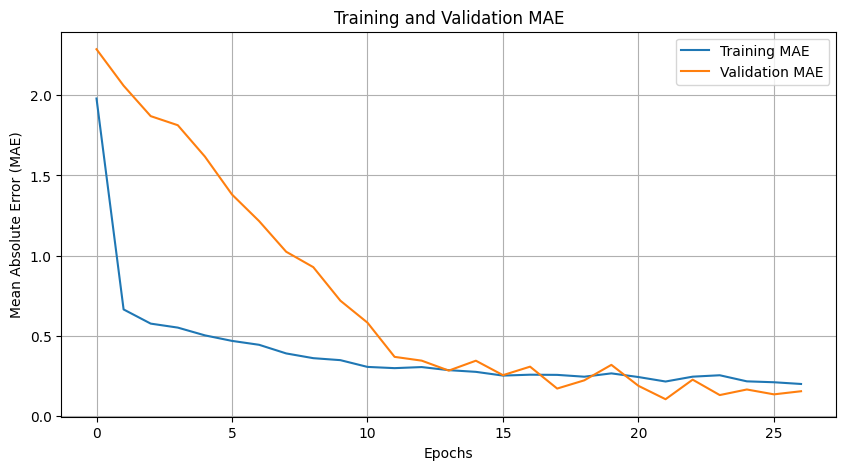

In [22]:
if 'mae' in history_data and 'val_mae' in history_data:
    plt.figure(figsize=(10, 5))
    plt.plot(history_data['mae'], label='Training MAE')
    plt.plot(history_data['val_mae'], label='Validation MAE')
    plt.xlabel('Epochs')
    plt.ylabel('Mean Absolute Error (MAE)')
    plt.title('Training and Validation MAE')
    plt.legend()
    plt.grid()
    plt.show()
else:
    print("MAE or Validation MAE not found in history.")

In [24]:
print(X_train_reshaped.shape)  # Harus [batch_size, 10, 1]
print(X_test_reshaped.shape)   # Harus [batch_size, 10, 1]


(690, 9, 1)
(173, 9, 1)


In [25]:
import numpy as np
from tensorflow.keras.models import load_model

model_test = load_model('/home/rapuri/Python/capstone/expense_prediction_model_fixed.h5')

# Test input data
amount = 100000 # Input user
Lag_1_Expenses = 0  # Tidak ada pengeluaran sebelumnya
Lag_2_Expenses = 0  # Tidak ada pengeluaran sebelumnya
category_encoded = 1  # Contoh kategori
day_of_week = 2  # Hari Selasa
is_weekend = 0  # Bukan akhir pekan

# Preprocessing sesuai dengan langkah sebelumnya
amount /= 187.85
amount_log = np.log1p(amount)
day_of_week_sin = np.sin(2 * np.pi * day_of_week / 7)
day_of_week_cos = np.cos(2 * np.pi * day_of_week / 7)
smoothed_expenses = amount_log  # Input pertama, gunakan nilai log
rolling_avg_7 = amount_log  # Input pertama, gunakan nilai log
rolling_avg_30 = amount_log  # Input pertama, gunakan nilai log

# Gabungkan semua fitur
input_features = [
    Lag_1_Expenses, Lag_2_Expenses, category_encoded,
    day_of_week_sin, day_of_week_cos, is_weekend,
    smoothed_expenses, rolling_avg_7, rolling_avg_30
]

# Normalisasi input menggunakan scaler dari pelatihan
# input_scaled = scaler.transform([input_features])

# Reshape untuk model (3D input)
input_reshaped = np.array(input_features).reshape((1, len(input_features), 1))

# Prediksi menggunakan model
y_pred_log = model_test.predict(input_reshaped)[0][0]

# Konversi hasil prediksi ke skala asli
y_pred_original = np.expm1(y_pred_log)

y_pred_original *= 187.85
# Tampilkan hasil
print(f"Input Features (Preprocessed): {input_features}")
# print(f"Input Features (Scaled): {input_scaled}")
print(f"Prediksi (Log Scale): {y_pred_log:.4f}")
print(f"Prediksi (Original Scale): Rp. {y_pred_original:,.2f}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 829ms/step
Input Features (Preprocessed): [0, 0, 1, np.float64(0.9749279121818236), np.float64(-0.22252093395631434), 0, np.float64(6.2791584307756105), np.float64(6.2791584307756105), np.float64(6.2791584307756105)]
Prediksi (Log Scale): 6.5337
Prediksi (Original Scale): Rp. 129,040.37


6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 191ms/step
Mean Absolute Error (MAE): 0.1057
Mean Squared Error (MSE): 0.0208
Root Mean Squared Error (RMSE): 0.1443
R² (R-squared) Score: 0.9742


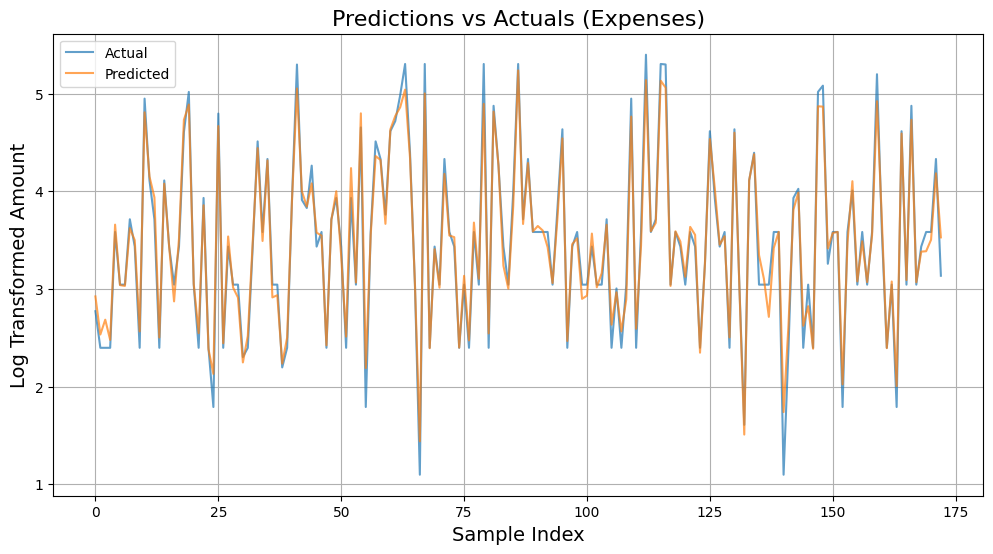

In [26]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

# Predict on the test set
y_pred = model.predict(X_test_reshaped).flatten()

# Evaluasi metrik
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"R² (R-squared) Score: {r2:.4f}")

# Visualisasi prediksi vs nilai aktual
plt.figure(figsize=(12, 6))
plt.plot(y_test, label='Actual', linestyle='-', alpha=0.7)
plt.plot(y_pred, label='Predicted', linestyle='-', alpha=0.7)
plt.title('Predictions vs Actuals (Expenses)', fontsize=16)
plt.xlabel('Sample Index', fontsize=14)
plt.ylabel('Log Transformed Amount', fontsize=14)
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
model.compile(optimizer='adam', loss=tf.keras.losses.MeanSquaredError(), metrics=['mae'])
# # Simpan model
model.save('expense_prediction_model_fixed.h5')